In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import pandas as pd

In [77]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [79]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [81]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
# Sort the dataframe by date
rain_df = pd.DataFrame(rain)
rain_df.head()

# Use Pandas Plotting with Matplotlib to plot the data


('2017-08-23',)
2016-08-23


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [85]:
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


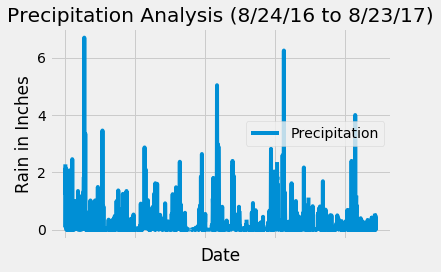

In [86]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [87]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [88]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [89]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [90]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

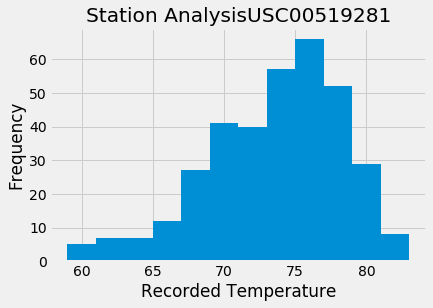

In [104]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis" + busiest)
plt.show()

![precipitation](Images/station-histogram.png)

In [92]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# calculate the min/max/avg from last year that matches my trip date
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67.0, 74.47368421052632, 82.0)]


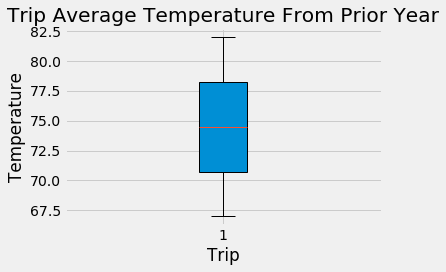

In [94]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

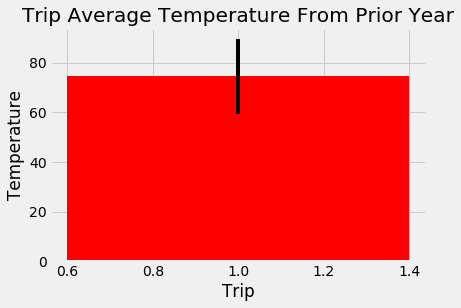

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)


## Optional Challenge Assignment

In [96]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurement.date).filter(extract('month', Measurement.date)==trip_month).\
             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date).all()
subquery

[('2010-08-15'),
 ('2011-08-15'),
 ('2012-08-15'),
 ('2013-08-15'),
 ('2014-08-15'),
 ('2015-08-15'),
 ('2016-08-15'),
 ('2017-08-15')]

In [99]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurement.date.label("dates"), func.max(Measurement.tobs).label("max_tobs"),\
                             func.min(Measurement.tobs).label("min_tobs"),func.avg(Measurement.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurement.date)==trip_month).\
                             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()

('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [100]:
lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)

2017-04-01
2017-04-15


In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    order_by(Measurement.station).all()

In [102]:
vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,1.64
USC00514830,0.90
USC00516128,5.75
USC00517948,0.00
USC00519281,4.14
USC00519397,0.27
USC00519523,0.36


In [105]:
Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()

,TMAX,TMIN,TAVG
Date,,,
2017-08-01,77.0,72.0,74.5
2017-08-02,83.0,73.0,79.0
2017-08-03,81.0,76.0,79.0
2017-08-04,82.0,77.0,80.0
2017-08-05,82.0,77.0,80.0


<Figure size 648x792 with 0 Axes>

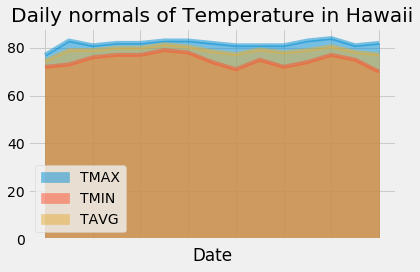

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
fig = plt.figure(figsize=(9, 11))
ax = Daily_normals_df.plot(kind='area', stacked=False, title='Daily normals of Temperature in Hawaii')
ax.set_xlabel('Date')
plt.tight_layout()
plt.savefig('Daily normals of Temperature in Hawaii.png', bbox_inches = 'tight')
plt.show()